In [1]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')


2025-01-05 01:21:43.110986: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-05 01:21:43.180594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736011303.234148   45209 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736011303.246512   45209 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 01:21:43.307850: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
df_train.columns = ['label', 'title', 'text']
df_train.head()

,label,title,text
0,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
1,2,Amazing!,This soundtrack is my favorite music of all ti...
2,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
3,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."
4,2,an absolute masterpiece,I am quite sure any of you actually taking the...


In [4]:
df_test.columns = ['label', 'title', 'text']
df_test.head()

,label,title,text
0,2,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...
2,2,"works fine, but Maha Energy is better",Check out Maha Energy's website. Their Powerex...
3,2,Great for the non-audiophile,Reviewed quite a bit of the combo players and ...
4,1,DVD Player crapped out after one year,I also began having the incorrect disc problem...


In [5]:
df_train = df_train.head(500000)
df_test = df_test.head(50000)

In [6]:
def concat_columns(df, col1, col2, new_col):
    df[new_col] = df[col1].apply(str) + ' ' + df[col2].apply(str)
    df.drop(col2, axis = 1, inplace = True)
    return df

df_train = concat_columns(df_train, 'text', 'title', 'text')
df_test = concat_columns(df_test, 'text', 'title', 'text')

# Map labels for binary classification
df_train['label'] = df_train['label'].map({1: 0, 2: 1})
df_test['label'] = df_test['label'].map({1: 0, 2: 1})



In [7]:
df_train.head()

,label,text
0,1,I'm reading a lot of reviews saying that this ...
1,1,This soundtrack is my favorite music of all ti...
2,1,I truly like this soundtrack and I enjoy video...
3,1,"If you've played the game, you know how divine..."
4,1,I am quite sure any of you actually taking the...


data clean

In [8]:
def clean_text(text):
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)  # Keep only letters
    #text = re.sub('book|one', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove spaces
    return text

df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)


In [9]:
df_train.head()

,label,text
0,1,im reading a lot of reviews saying that this i...
1,1,this soundtrack is my favorite music of all ti...
2,1,i truly like this soundtrack and i enjoy video...
3,1,if youve played the game you know how divine t...
4,1,i am quite sure any of you actually taking the...


In [10]:
max_words = 10000
max_len = 530

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['text'])

train_sequences = tokenizer.texts_to_sequences(df_train['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

word_index = tokenizer.word_index 

train_pad = pad_sequences(train_sequences, maxlen=max_len)
test_pad = pad_sequences(test_sequences, maxlen=max_len)


In [10]:
df_train.head()

,label,text
0,1,im reading a lot of reviews saying that this i...
1,1,this soundtrack is my favorite music of all ti...
2,1,i truly like this soundtrack and i enjoy video...
3,1,if youve played the game you know how divine t...
4,1,i am quite sure any of you actually taking the...


In [19]:
model = tf.keras.Sequential()
model.add(Embedding(max_words, 16, input_length=max_len))
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2)) 
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dropout(0.5))  
model.add(Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
model.add(tf.keras.layers.Dropout(0.5))  
model.add(Dense(1, activation='sigmoid'))


model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.build(input_shape=(None, max_len))

model.summary()

/home/kenny1208/anaconda3/envs/TF_GPU/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 530, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 528, 16)        │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 264, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 262, 32)        │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 131, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,441 (638.44 KB)

 Trainable params: 163,441 (638.44 KB)

 Non-trainable params: 0 (0.00 B)

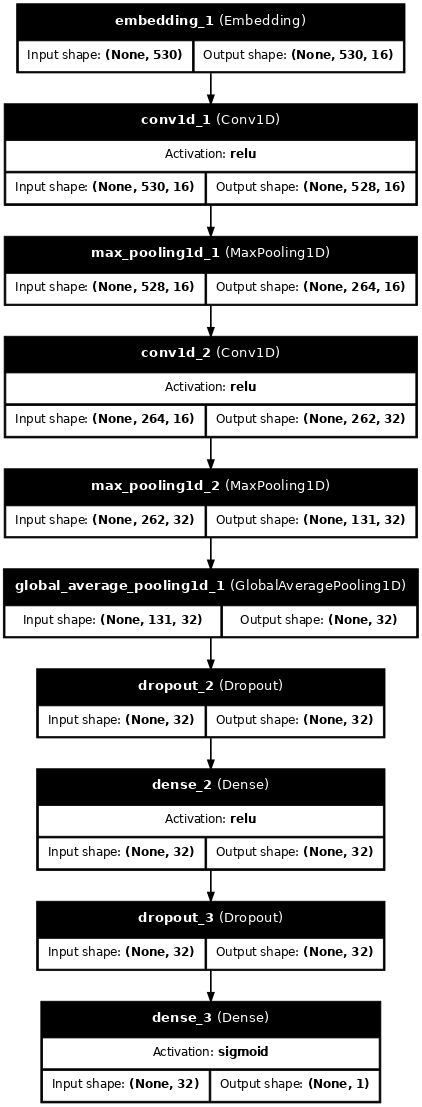

In [22]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True, dpi=60, show_layer_activations=True, expand_nested=True)

In [23]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

history = model.fit(
    train_pad,
    df_train['label'],
    validation_split=0.1,
    epochs=10,
    batch_size=64
)

Epoch 1/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 33s 4ms/step - accuracy: 0.7915 - loss: 0.4589 - val_accuracy: 0.9028 - val_loss: 0.2534
Epoch 2/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8964 - loss: 0.2766 - val_accuracy: 0.9114 - val_loss: 0.2325
Epoch 3/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9075 - loss: 0.2520 - val_accuracy: 0.9127 - val_loss: 0.2264
Epoch 4/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9141 - loss: 0.2355 - val_accuracy: 0.9154 - val_loss: 0.2215
Epoch 5/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9201 - loss: 0.2227 - val_accuracy: 0.9157 - val_loss: 0.2213
Epoch 6/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.9233 - loss: 0.2156 - val_accuracy: 0.9160 - val_loss: 0.2211
Epoch 7/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9277 - loss: 0.2051 - val_accuracy: 0.9161 - val_loss: 0.2222
Epoch 8/10
7032/7032 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9313 - loss: 0

In [24]:
model.evaluate(test_pad, df_test['label'])

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9109 - loss: 0.2450


[0.24481238424777985, 0.9109799861907959]

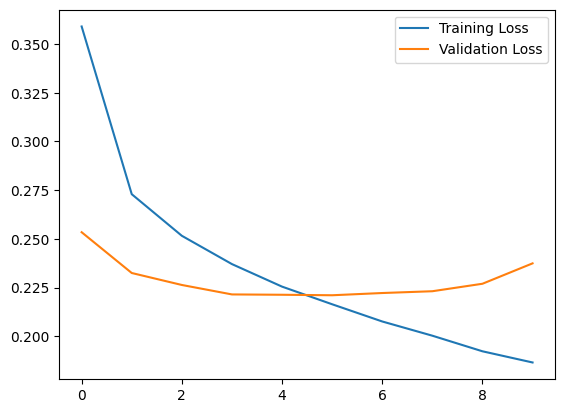

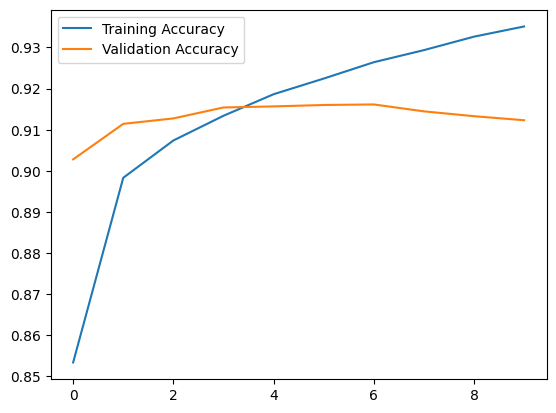

In [25]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [26]:
model.save('CNN_model.h5')

In [12]:
model = load_model('CNN_model.h5')

# Function to preprocess new text 
def preprocess_text(text):
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)
    return padded_sequence

# Function to predict sentiment
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    prediction = model.predict(processed_text)
    return prediction[0][0]

new_review = "If you’re looking for mediocrity, this is the perfect product."
sentiment_score = predict_sentiment(new_review)
print(f"Sentiment Score: {sentiment_score}")

if sentiment_score > 0.5:
    print("Recommend this product.")
else:
    print("Do not recommend this product.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
Sentiment Score: 0.13224181532859802
Do not recommend this product.
